# Creating Network Model of Mastodon 

**Questions:**
- Can user be a part of instance without any edges? Done via node label. If not, makes assumption that all users who join an instance immediately follow someone within that instance. Making this assumption allows for more clear visualizations because a node "in" an instance whose first edge is outside that instance will be positioned within a that outside instance rather than it's own

**Goal Network Dynamics:** <br>
Scale free (Barabos?), aka power law, within an instance, small world-like probability of rewiring an edge to ANY node w/ scale free probability

**Overview of Possible Steps:** <br>
Start with **set number of instances (currently trying this approach)** or just 1 node and add instances during simulation? For each time step: 
- Add a node
- Determine which "instance" node should be in using rich-get-richer dynamics
- Pick One: **Create edge to node within that instance  (currently trying this approach)**; or just label node as part of that instance
- Select a random node
- Use small-world probability to determine whether that node creates edge to another node within instance or outside of instance
- Randomly determine edge target, considering either population of nodes within instance or population of nodes outside instance

## Import Packages

In [1]:
import networkx as nx
import numpy as np
import plotly.graph_objects as go
from itertools import count

## Set Plotly Options

In [16]:
def do_plotly(G, pos=None):
    # Default Network Layout
    if pos == None:
        pos=nx.fruchterman_reingold_layout(G)

        
    # Create Edges
    edge_x = []
    edge_y = []
    for edge in G.edges():
        # x0, y0 = G.nodes[edge[0]]['pos']
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        edge_x.append(x0)
        edge_x.append(x1)
        edge_x.append(None)
        edge_y.append(y0)
        edge_y.append(y1)
        edge_y.append(None)

    edge_trace = go.Scatter(
        x=edge_x, y=edge_y,
        line=dict(width=0.5, color='#888'),
        hoverinfo='none',
        mode='lines')

    node_x = []
    node_y = []
    for node in G.nodes():
        # x, y = G.nodes[node]['pos']
        x, y = pos[node]
        node_x.append(x)
        node_y.append(y)

    node_trace = go.Scatter(
        x=node_x, y=node_y,
        mode='markers',
        hoverinfo='text',
        marker=dict(
            showscale=True,
            # Colorscale options
            # 'Greys' | 'YlGnBu' | 'Greens' | 'YlOrRd' | 'Bluered' | 'RdBu' |
            # 'Reds' | 'Blues' | 'Picnic' | 'Rainbow' | 'Portland' | 'Jet' |
            # 'Hot' | 'Blackbody' | 'Earth' | 'Electric' | 'Viridis' |
            colorscale='YlGnBu',
            reversescale=True,
            color=[],
            size=10,
            colorbar=dict(
                thickness=15,
                title='Node Connections',
                xanchor='left',
                titleside='right'
            ),
            line_width=2))

    
    # Color Node Point
    node_adjacencies = []
    node_text = []
    for node, adjacencies in enumerate(G.adjacency()):
        node_adjacencies.append(len(adjacencies[1]))
        node_text.append('label: '+str(node)+'# of connections: '+str(len(adjacencies[1])))

    node_trace.marker.color = node_adjacencies
    node_trace.text = node_text

    
    # Create Network Graph
    fig = go.Figure(data=[edge_trace, node_trace],
                layout=go.Layout(
                    title='<br>Network graph made with Python',
                    titlefont_size=16,
                    showlegend=False,
                    hovermode='closest',
                    margin=dict(b=20,l=5,r=5,t=40),
                    annotations=[ dict(
                        text="Python code: <a href='https://plotly.com/ipython-notebooks/network-graphs/'> https://plotly.com/ipython-notebooks/network-graphs/</a>",
                        showarrow=False,
                        xref="paper", yref="paper",
                        x=0.005, y=-0.002 ) ],
                    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                )
    fig.show()

## Define Function to Select Instance to Create Node Within 

In [74]:
def preferential_attachment(G, stubs, instances, p): 
    # ADDING NODE
    # Add new node
    new_node = G.number_of_nodes()
    G.add_node(new_node)
    
    # Determine which instance to add to
    # Randomly choose from list of instances
#     chosen_instance = np.random.choice(list(instances.keys()))
    # OR
    # Randomly select node and choose the instance that node is in 
    chosen_instance = G.nodes[np.random.choice(stubs)]['instance']
    
    # Select random node within instance to create edge to
    neighbor = np.random.choice(instances[chosen_instance])
    
    # Add edge
    G.add_edge(new_node, neighbor)
    
    # Update attributes and history 
    G.nodes[new_node]['state'] = 1
    G.nodes[neighbor]['state'] += 1
    G.nodes[new_node]['instance'] = chosen_instance
    instances[chosen_instance].append(new_node)
    stubs.append(new_node)
    stubs.append(neighbor)
    
    
    # REWIRING
    # Select random node to make edge from
    rand_node = np.random.choice(stubs)
    rand_node_instance = G.nodes[rand_node]['instance']
    
    # If probability met, attach to random node in external instance, else, 
    # attach inside current instance
    possible_nodes = []
    rand_num = np.random.uniform(0, 1)
    if rand_num <= p:
        external_instances = list(instances.keys())
        external_instances.remove(rand_node_instance)
        for i in range(0, len(external_instances)):
            for j in range(0, len(instances[external_instances[i]])):
                possible_nodes.append(instances[external_instances[i]][j])
        neighbor = np.random.choice(possible_nodes)
    else:
        neighbor = np.random.choice(instances[rand_node_instance])
        
    # Add edge
    G.add_edge(rand_node, neighbor)
    
    # Update attributes and history 
    G.nodes[rand_node]['state'] += 1
    G.nodes[neighbor]['state'] += 1
    stubs.append(rand_node)
    stubs.append(neighbor)
    
    
    return(G, stubs, instances)

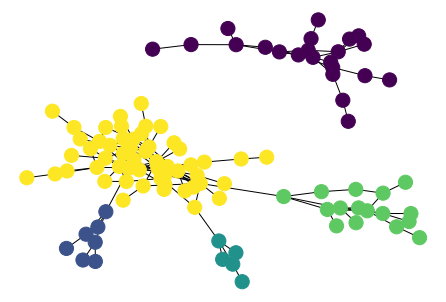

In [99]:
G = nx.Graph()
stubs = []
num_instances = 5
instances = {}
p = 0.05

# Creates new instances with one node each
for i in range(0, num_instances):
    # Adds node to instance
    G.add_node(i)
    
    # Adds node to history list
    stubs.append(i)
    
    # Adds attribute to keep track of degrees of node
    G.nodes[i]['state'] = 0

    # Adds attribute that keeps track of which instance node is in
    G.nodes[i]['instance'] = i
    
    # Adds new node to dictionary for instances
    instances[i] = [i]

# Finds which instance each node is in
# nodes_instance = nx.get_node_attributes(G, 'instance')

# Run simulation
for step in range(100):
    (G, stubs, instances) = preferential_attachment(G, stubs, instances, p)

# Map colors
groups = set(nx.get_node_attributes(G, 'instance').values())
# groups = set(nx.get_node_attributes(G, 'state').values())
mapping = dict(zip(sorted(groups), count()))
colors = [mapping[G.nodes[n]['instance']] for n in G.nodes()]

# Display network
nx.draw(G, with_labels=False, node_size=200, pos=nx.fruchterman_reingold_layout(G), node_color=colors)

In [100]:
do_plotly(G)